# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Имеется набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
photos = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1/255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=photos,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
photos.shape

(7591, 2)

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

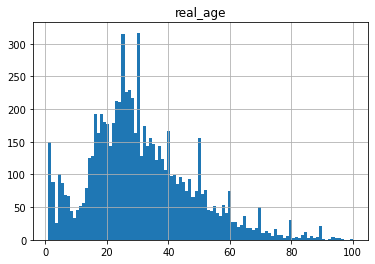

In [4]:
photos.hist(bins=100)

In [5]:
print(photos.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


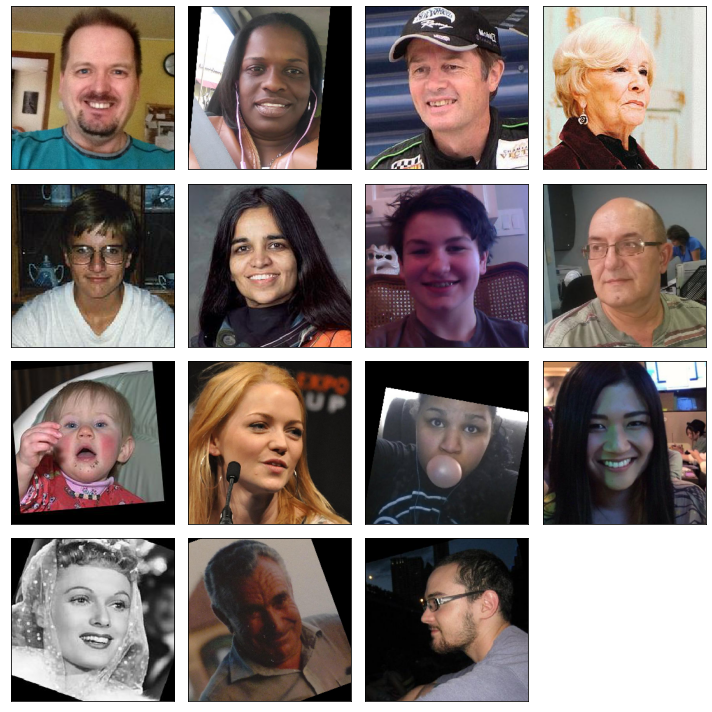

In [6]:
features, target = next(gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете фотографии людей возрастом от 1 до 100 лет, при этом отмечается неравномерное распределение по возрасту - преобладают фотографии людей возрастом 20-40 лет. 75% фотографий - это люди возрастом до 41 года.
Для увеличения качества выборки применим методы аугментации - отражение по горизонтали.

## Обучение модели

***Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке***

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rotation_range=45 rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 46s - loss: 222.2612 - mae: 10.7860 - val_loss: 537.4827 - val_mae: 17.8713
Epoch 2/10
356/356 - 38s - loss: 84.9321 - mae: 7.0084 - val_loss: 111.3930 - val_mae: 8.1530
Epoch 3/10
356/356 - 38s - loss: 58.3627 - mae: 5.8420 - val_loss: 76.8996 - val_mae: 6.5961
Epoch 4/10
356/356 - 38s - loss: 41.6588 - mae: 4.9558 - val_loss: 80.6921 - val_mae: 6.9961
Epoch 5/10
356/356 - 38s - loss: 31.6474 - mae: 4.3112 - val_loss: 72.0462 - val_mae: 6.2460
Epoch 6/10
356/356 - 38s - loss: 26.1745 - mae: 3.8996 - val_loss: 84.9871 - val_mae: 6.8653
Epoch 7/10
356/356 - 38s - loss: 21.4802 - mae: 3.5332 - val_loss: 70.4136 - val_mae: 6.1995
Epoch 8/10
356/356 - 38s - loss: 16.7125 - mae: 3.1351 - val_loss: 73.6569 - val_mae: 6.3912
Epoch 9/10
356/356 - 38s - loss: 14.7960 - mae: 2.9535 - val_loss: 65.9136 - val_mae: 6.0771
Epoch 10/10
356/356 - 38s - loss: 13.3152 - mae: 2.7801 - val_loss: 68.2143 - val_mae: 6.1546

119/119 - 9s - loss: 68.2143 - mae: 6.1546
Test MAE: 6.1546
```

## Анализ обученной модели

**Построена модель на основе ResNet50 со слоем GlobalAveragePooling2D и одним полносвязным слоем, функцией потери которой является MSE.
Полученный на тестовой выборке MAE 6,2 является отличным результатом - ошибиться в возрасте на 6 лет свойственно даже человеку.**